In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Map(dict):
    """
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(Map, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.items():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(Map, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)
        del self.__dict__[key]

In [3]:
def sample_trunc_normal(mu, sd = 1):
    x = np.random.normal(loc = mu, scale = sd, size = 1)
    if x > 0:
        return x
    else:
        return 0
    
def sample_poisson_trunc_normal(n, mu, sd, seed = 123):
    np.random.seed(seed)
    lam = [sample_trunc_normal(mu, sd) for i in range(n)]
    print(len(lam))
    x = np.random.poisson(lam = lam)
    return {"lam":lam, "x":x}

* Simulate data: $\lambda$s are from truncated normal; †hen $x \sim Pois(\lambda)$. I plot the histogram of data below. 
* Model: specified in the `args` class. 

5000


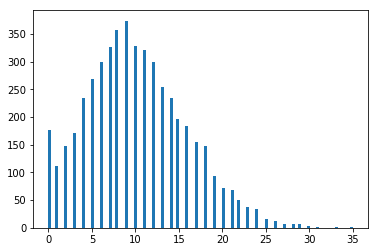

In [4]:
## simulate data
n = 5000
mu = 10
sd = 5
sim = sample_poisson_trunc_normal(n, mu,sd, seed = 123)
plt.hist(sim["x"], bins=100)
plt.show()

## model arguments
args = Map(batch_size = n, epochs = 2000, no_cuda = 1, seed = 123, log_interval= 10)
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

data = torch.Tensor(sim["x"].reshape(-1,1))
train_loader = torch.utils.data.DataLoader(data, 
                                           batch_size=args.batch_size, shuffle=False, **kwargs)


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        mid_len = 10
        self.fc1 = nn.Linear(1, mid_len)
        self.fc21 = nn.Linear(mid_len, 1)
        self.fc22 = nn.Linear(mid_len, 1)
#         self.fc3 = nn.Linear(1, mid_len)
#         self.fc4 = nn.Linear(mid_len, 1)
        self.fc3 = nn.Linear(1, 1)


    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         h4 = self.fc4(h3).clamp(min = 1e-5)
        #h4 = F.softplus(self.fc4(h3))
        h3 = self.fc3(z).clamp(min = 1e-5)
        return h3

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1))
        z = self.reparameterize(mu, logvar)
        theta = self.decode(z)
        return theta, mu, logvar
    
        
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(theta, x, mu, logvar):
    poisson_ll = (- theta + x * torch.log(theta)).sum()
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    neg_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return - poisson_ll + neg_KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        theta_batch, mu, logvar = model.forward(data)
        loss = loss_function(theta_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return data


if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        data = train(epoch)

The avergae loss goes down from $52$ to $-11$ in 2000 iterations. 

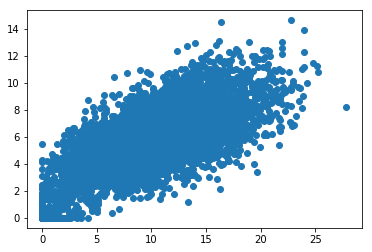

In [11]:
lam, mu, logvar = model.forward(data)
plt.scatter(sim["lam"], lam.tolist())
plt.show()